# Day 07: Green

I iterated on a few different data types from OSM, starting with national parks. However, I ultimately found the format of the data to be inconvenient for visual purposes. So, in the end, I stuck with cycleways.

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

import osmnx as ox
import overpass

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Desired styling for matplotlib
from matplotlib import cycler
colors = cycler('color',["44aa98","ab4498","332389","86ccec","ddcc76","cd6477","882255", "117732"])
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['text.color'] = '212121'
plt.rcParams['xtick.color'] = '212121'
plt.rcParams['ytick.color'] = '212121'
plt.rcParams['font.family'] = 'sans serif'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['axes.edgecolor'] = 'dimgray'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = 'x-small'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'None'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'
plt.rc('axes', prop_cycle=colors)

# Cycleways from OSM


In [3]:
# Define query
region_type, region_name = 'city', 'montreal'
query = {region_type: region_name}

# Configure osmnx
ox.config(use_cache=True, log_console=True)

# Arrange as geodataframe
adm = ox.geocode_to_gdf(query)

# Preview
adm

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-73.97416 45.46643, -73.93702 45.451...",45.70479,45.410076,-73.474295,-73.974157,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736


In [4]:
# Find cycleways in boundary

# Configure Overpass API
# NOTE: There are some limited requests per length of time on this API
endpoint = "https://overpass-api.de/api/interpreter"
api = overpass.API(timeout=100, endpoint=endpoint)

# Get bounding box of region
lats = adm.iloc[0][['bbox_south', 'bbox_north']].values
lons = adm.iloc[0][['bbox_east', 'bbox_west']].values
bbox = [lats.min(), lons.min(), lats.max(), lons.max()]
bbox_str = ",".join([str(b) for b in bbox])

# Arrange query
query = '''way["cycleway"](''' +  bbox_str + '''); out geom;'''

# Get response
result = api.get(query, responseformat="geojson")

# Arrange into dataframe
df = pd.DataFrame(result)

# Explode features into columns
df = pd.concat([df, df['features'].apply(pd.Series)], axis=1)

# Explode properties into columns
df = pd.concat([df, df['properties'].apply(pd.Series)], axis=1)

# Parse geometry and save as geodataframe
paths = gpd.GeoDataFrame(df.drop(columns="geometry"), geometry=df.geometry.apply(shape), crs='EPSG:4326')

# Filter out results that are not within administrative boundaries
paths_poly = gpd.overlay(paths, adm, how='intersection')

# Preview
print(f"Found {paths_poly.shape[0]:,.0f} cycleways")
paths_poly.head(5)

Found 1,500 cycleways


,type_1,type_1,features,type_1,type_1,id,properties,bicycle,cycleway,highway,...,place_id,osm_type,osm_id,lat,lon,display_name,class,type_2,importance,geometry
0,FeatureCollection,Feature,"{'type': 'Feature', 'id': 4848048, 'geometry':...",FeatureCollection,Feature,4848048,"{'bicycle': 'designated', 'cycleway': 'shared_...",designated,shared_lane,residential,...,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736,"LINESTRING (-73.68373 45.50745, -73.68353 45.5..."
1,FeatureCollection,Feature,"{'type': 'Feature', 'id': 4864457, 'geometry':...",FeatureCollection,Feature,4864457,"{'cycleway': 'lane', 'highway': 'residential',...",None,lane,residential,...,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736,"LINESTRING (-73.70922 45.51472, -73.71102 45.5..."
2,FeatureCollection,Feature,"{'type': 'Feature', 'id': 4886242, 'geometry':...",FeatureCollection,Feature,4886242,"{'cycleway': 'lane', 'highway': 'tertiary', 'l...",None,lane,tertiary,...,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736,"LINESTRING (-73.61626 45.50614, -73.61584 45.5..."
3,FeatureCollection,Feature,"{'type': 'Feature', 'id': 4886357, 'geometry':...",FeatureCollection,Feature,4886357,"{'cycleway': 'lane', 'highway': 'tertiary', 'i...",None,lane,tertiary,...,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736,"LINESTRING (-73.59171 45.50751, -73.59274 45.5..."
4,FeatureCollection,Feature,"{'type': 'Feature', 'id': 4886374, 'geometry':...",FeatureCollection,Feature,4886374,"{'cycleway': 'lane', 'highway': 'secondary', '...",None,lane,secondary,...,282212108,relation,1634158,45.503182,-73.569806,"Montreal, Urban agglomeration of Montreal, Mon...",boundary,administrative,0.811736,"LINESTRING (-73.57855 45.51120, -73.57827 45.5..."


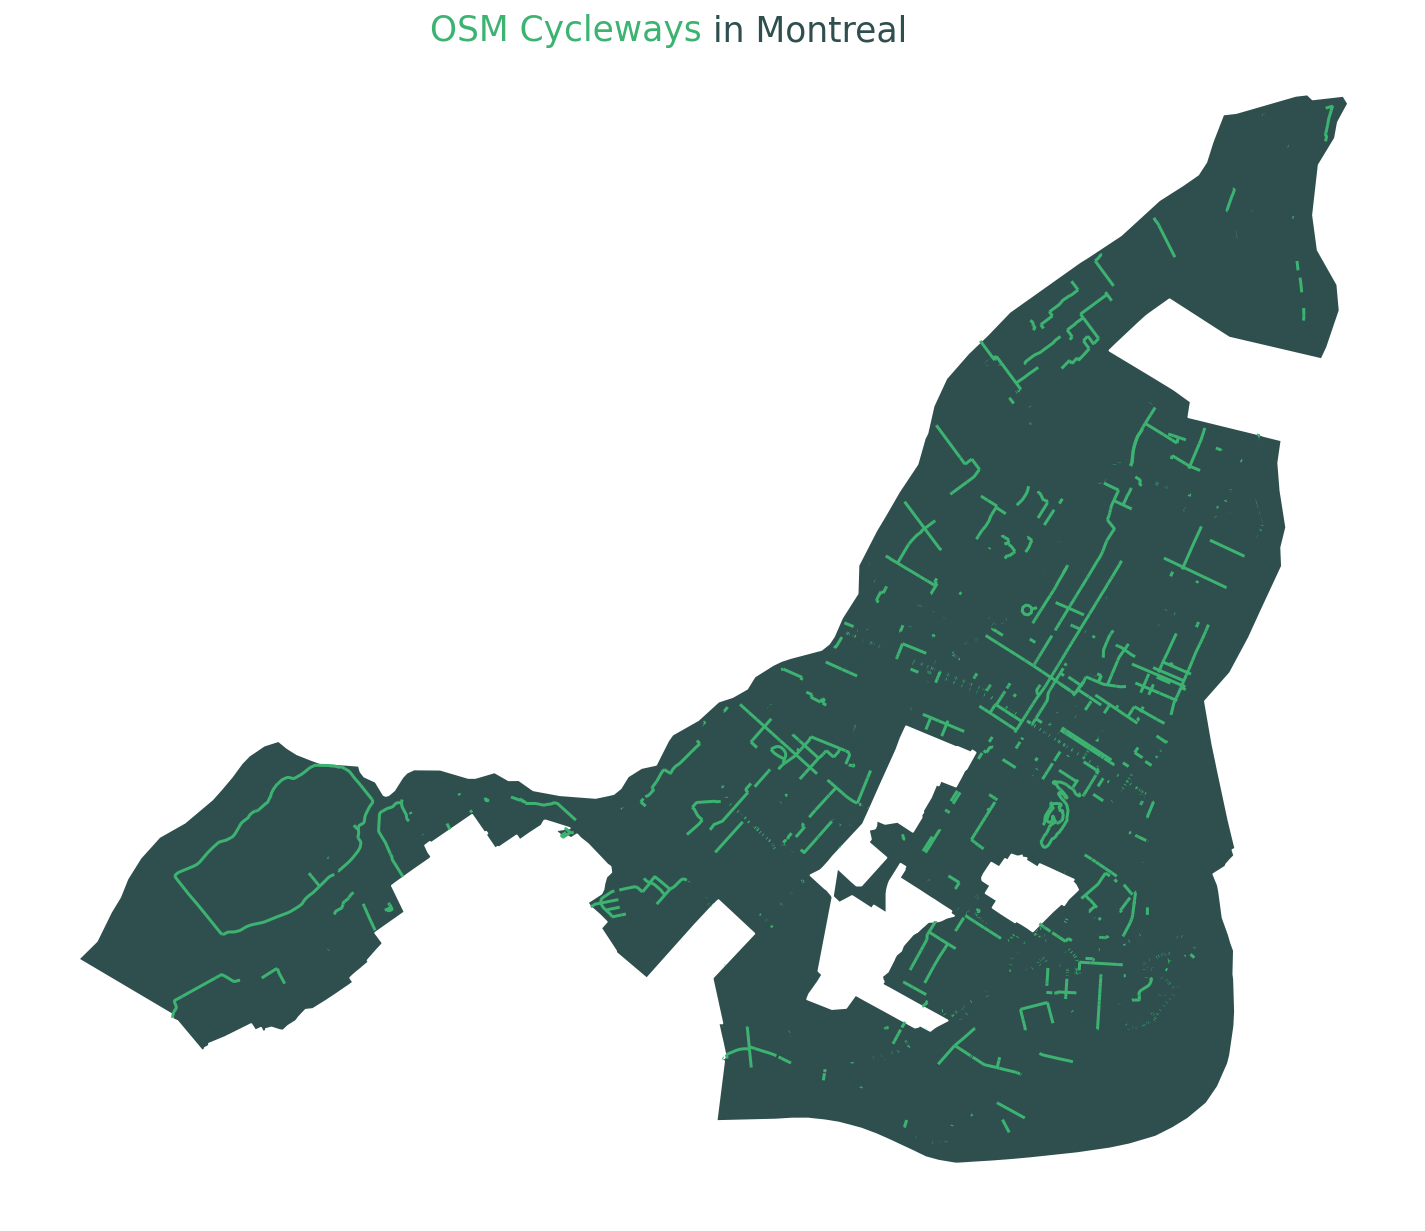

In [5]:
# Construct plot
fig, ax = plt.subplots(figsize=(10,10))
adm.plot(ax=ax, edgecolor='w', facecolor='DarkSlateGray', zorder=1)
paths_poly.plot(ax=ax, color="MediumSeaGreen", zorder=2)
ax.annotate(f"OSM Cycleways ", xy=(0.5,1), xycoords='axes fraction', color='MediumSeaGreen', ha='right', fontsize="xx-large")
ax.annotate(f"in {region_name.title()}", xy=(0.5,1), xycoords='axes fraction', color='DarkSlateGray', ha='left', fontsize="xx-large")
ax.axis('off')
plt.tight_layout()

# Write to path
out_path = os.path.join("..", "contributions", f"07_{region_name.title()}")
fig.savefig(out_path, facecolor="w", dpi=300)

# Preview
plt.show()